In [31]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
attributesInput = pd.read_csv('../Dataset/AttributesF.csv')
emailDataInput = pd.read_csv('../Dataset/FinalEdata.csv')
conflictsInput = pd.read_csv('../Dataset/TC2.csv')

C:\Users\곰단\AppData\Local\Temp\ipykernel_4816\2029714194.py:7: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  emailDataInput = pd.read_csv('../Dataset/FinalEdata.csv')


In [32]:
attributes = attributesInput

In [33]:
conflicts = conflictsInput.set_index(['Source'])
conflicts = conflicts.stack().to_frame()
conflicts = conflicts.rename_axis(['sjt', 'ojt']).reset_index()
conflicts = conflicts.rename(columns={0: 'type'}) 
conflicts = conflicts.astype({'type': 'int32'})
conflicts = conflicts.astype({'ojt': 'int32'})

In [34]:
conflicts = conflicts.merge(attributesInput, how='left', left_on='sjt', right_on='ID')
conflicts = conflicts.drop(columns=['ID', 'Gender', 'Age', 'Tenure_Full', 'Supervisor_T1', 'Hierarchical Level'])
conflicts = conflicts.rename(columns={'Department': 'dep_sjt'})
conflicts = conflicts.merge(attributesInput, how='left', left_on='ojt', right_on='ID')
conflicts = conflicts.drop(columns=['ID', 'Gender', 'Age', 'Tenure_Full', 'Supervisor_T1', 'Hierarchical Level'])
conflicts = conflicts.rename(columns={'Department': 'dep_ojt'})
conflicts = conflicts.astype({'dep_sjt': 'int16', 'dep_ojt': 'int16'})
conflicts = conflicts.loc[conflicts['type'] == 1]

Remove rows that are between the same people e.g. if sjt 1 ojt 2 exists sjt 2 ojt 1 is removed

In [35]:
delrows = []
droppedrows = 0
for row in conflicts.iterrows():
    duplicates = conflicts[((conflicts['ojt'] == row[1]['sjt']) & (conflicts['sjt'] == row[1]['ojt']))]
    if not duplicates.empty:
        #print(duplicates)
        for duplicate in duplicates.iterrows():
            if duplicate[0] not in delrows:
                droppedrows += 1
                #print(duplicate[0], row[0])
                delrows.append(row[0])
                conflicts.drop(duplicate[0], inplace=True)

In [36]:
cc_centralization = []
cc_density = []
department_no = []
for i in range(1, 13):
    target_dept = i
    #print("Dept:", target_dept)
    if target_dept != 4:
        department_no.append(target_dept)
        dept = conflicts.loc[ ((conflicts['dep_sjt'] == target_dept) | (conflicts['dep_ojt'] == target_dept)) ]
        G = nx.from_pandas_edgelist(dept, 'sjt', 'ojt', create_using=nx.Graph)
        max = 0
        for node in G:
            num_conflicts = len(dept.loc[dept['sjt'] == node].index)+len(dept.loc[dept['ojt'] == node].index)
            #print('ID: ', node, 'Conflicts: ', num_conflicts)
            if num_conflicts > max:
                max = num_conflicts
        #print("Max number of Edges on a node: ", max)
        #print("Number of Nodes: ", len(G))
        sum = 0
        for node in G:
            num_conflicts = len(dept.loc[dept['sjt'] == node].index)+len(dept.loc[dept['ojt'] == node].index)
            #print("ID:", node, "Num_conflicts:", num_conflicts)
            sum = sum + (max - num_conflicts)
        #print("Sum: ", sum)
        denominator = ((len(G)-1) * (len(G)-2))
        #print("Denominator: ", denominator)
        centralization = sum / denominator
        cc_centralization.append(centralization)
        #print("Centralization: ,", centralization)
        density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes()-1))
        cc_density.append(density)
        #print("Density: ,", density)

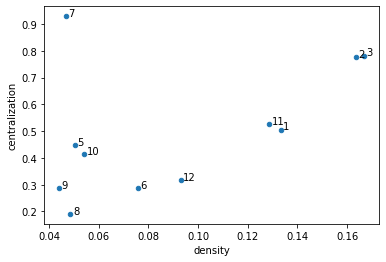

In [37]:
#print(len(cc_density), len(ccc_entralization), len(department_no))
con = pd.DataFrame({'x': cc_density,
                    'y': cc_centralization,
                    'department': department_no})

ax = con.plot.scatter(x='x', y='y')

for i, txt in enumerate(con.department):
    ax.annotate(txt, (con.x.iat[i]+0.001, con.y.iat[i]))
ax.set_xlabel("density")
ax.set_ylabel("centralization")
plt.show()

In [38]:
import statsmodels.api as sm
mod = sm.OLS(cc_density, cc_centralization)
result = mod.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              43.09
Date:                Mon, 01 Aug 2022   Prob (F-statistic):                    6.36e-05
Time:                        16:33:01   Log-Likelihood:                          18.645
No. Observations:                  11   AIC:                                     -35.29
Df Residuals:                      10   BIC:                                     -34.89
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

c:\Users\곰단\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
